Importing the required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
import tensorflow.keras as k

Downloading Kaggle Intel Image Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!pwd

/content


In [5]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [6]:
!kaggle datasets download -d puneet6060/intel-image-classification

100% 345M/346M [00:16<00:00, 26.5MB/s]
100% 346M/346M [00:16<00:00, 22.3MB/s]


In [7]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

Loading Train and Test Data

In [8]:
TRAINDATADIR = "/content/seg_train/seg_train"
TESTDATADIR = "/content/seg_test/seg_test"

CATEGORIES = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

-> Showing Sample Image

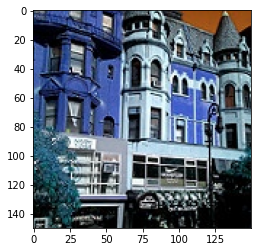

In [9]:
for category in CATEGORIES:
  path = os.path.join(TRAINDATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
    plt.imshow(img_array)
    plt.show()
    break
  break

Creating lists for training and test data

In [10]:
training_data = []
test_data = []

IMG_SIZE = 100        # Image size set to 100 px

def create_data(data_directory, datalist):
  for category in CATEGORIES:
    path = os.path.join(data_directory, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        datalist.append([new_array, class_num])
      except Exception as e:
        pass
  random.shuffle(datalist)
  return datalist

training_data = create_data(TRAINDATADIR, training_data)
test_data = create_data(TESTDATADIR, test_data)

In [11]:
print(f"Training Data size: {len(training_data)}")
print(f"Test Data size: {len(test_data)}")

Training Data size: 14034
Test Data size: 3000


Extracting labels from the dataset.

In [12]:
def label_ext(xlist, ylist, dataset, img_size, channels):
  for features, label in dataset:
    xlist.append(features)
    ylist.append(label)
  
  xlist = np.array(xlist).reshape(-1, img_size, img_size, channels)
  ylist = np.array(ylist).reshape(-1, 1)
  
  xlist = tf.convert_to_tensor(xlist, dtype=tf.float32)
  ylist = tf.convert_to_tensor(ylist, dtype=tf.float32)

  xlist = xlist/255.
  return xlist, ylist

In [13]:
xtrain = []
ytrain = []

xtest = []
ytest = []

xtrain, ytrain = label_ext(xtrain, ytrain, training_data, IMG_SIZE, channels=3)
xtest, ytest = label_ext(xtest, ytest, test_data, IMG_SIZE, channels=3)

In [14]:
print(f"xtrain: {xtrain.shape}")
print(f"ytrain: {ytrain.shape}")
print(f"xtest: {xtest.shape}")
print(f"ytest: {ytest.shape}")

xtrain: (14034, 100, 100, 3)
ytrain: (14034, 1)
xtest: (3000, 100, 100, 3)
ytest: (3000, 1)


Model

In [15]:
class Model(k.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.conv0 = k.layers.Conv2D(filters=64, kernel_size=3, activation="relu")
        self.maxp0 = k.layers.MaxPooling2D()
        self.bn0 = k.layers.BatchNormalization()
        self.conv1 = k.layers.Conv2D(filters=128, kernel_size=3, activation="relu")
        self.maxp1 = k.layers.MaxPooling2D()
        self.bn1 = k.layers.BatchNormalization()
        self.conv2 = k.layers.Conv2D(filters=256, kernel_size=3, activation="relu")
        self.maxp2 = k.layers.MaxPooling2D()
        self.bn2 = k.layers.BatchNormalization()
        self.globalpool = k.layers.GlobalAveragePooling2D()
        self.dropout = k.layers.Dropout(rate=0.5)
        self.dense0 = k.layers.Dense(units=128, activation="relu")
        self.dense1 = k.layers.Dense(units=64, activation="relu")
        self.dense2 = k.layers.Dense(units=6, activation="softmax")
        
    def call(self, inputs=k.Input(shape=(100, 100, 3)), training=False):
        output = self.conv0(inputs)
        output = self.maxp0(output)
        output = self.bn0(output)
        output = self.conv1(output)
        output = self.maxp1(output)
        output = self.bn1(output)
        output = self.conv2(output)
        output = self.maxp2(output)
        output = self.bn2(output)
        output = self.globalpool(output)
        output = self.dropout(output, training)
        output = self.dense0(output)
        output = self.dense1(output)
        output = self.dense2(output)
        return output

In [16]:
mdl = Model()
mdl.compile(optimizer="RMSprop",
           loss="sparse_categorical_crossentropy",
           metrics=["accuracy"])

Training

In [17]:
history = mdl.fit(xtrain,
                  ytrain,
                   epochs=100,
                   callbacks=[k.callbacks.EarlyStopping(monitor="val_loss",
                                                       patience=5,
                                                       restore_best_weights=True),
                             k.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                          patience=3)],
                 validation_split=0.1, batch_size=64)

Epoch 1/100
198/198 [==============================] - 19s 53ms/step - loss: 0.9935 - accuracy: 0.6089 - val_loss: 2.9144 - val_accuracy: 0.1774 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 9s 47ms/step - loss: 0.7454 - accuracy: 0.7238 - val_loss: 2.5203 - val_accuracy: 0.3298 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 9s 46ms/step - loss: 0.6516 - accuracy: 0.7603 - val_loss: 1.7934 - val_accuracy: 0.4387 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 9s 46ms/step - loss: 0.5763 - accuracy: 0.7869 - val_loss: 3.9323 - val_accuracy: 0.4217 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 9s 46ms/step - loss: 0.5208 - accuracy: 0.8115 - val_loss: 2.9088 - val_accuracy: 0.5157 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 9s 46ms/step - loss: 0.4800 - accuracy: 0.8295 - val_loss: 1.1241 - val_accuracy: 0.6332 - lr: 0.0010
Epoch 7/100
198/198 [==============================] - 9s

Visualization

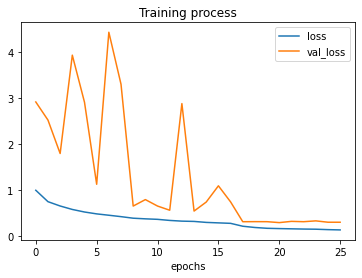

In [18]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.xlabel("epochs")
plt.title("Training process")
plt.show()

Testing the model

In [20]:
results = mdl.evaluate(xtest, ytest, verbose=0)
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]*100}")

Test loss: 0.3099839985370636
Test accuracy: 89.63333368301392
